In [ ]:
from apps import argentina
from textos import load_dicts
import pandas as pd
""" Este script toma los diccionarios hechos por la funcion dictionary de textos.py y
 genera .csv que tienen la cantidad de ocurrencias de las palabras por cada usuario.
"""
wcd = load_dicts(argentina)
words = wcd[0]
cant_words = wcd[1]
dicc_usuarios = wcd[2]

for p in argentina:
    df = pd.DataFrame.from_dict(dicc_usuarios[p],orient='index')
    #df = df.drop('user_id', 1)
    df.fillna(0,inplace=True)
    ser = df.sum(axis=0)
    df = df[df.sum(axis = 1) > 40]
    df = (df / ser)*1000000
    df.to_csv('./dataUsuarios/{0}.csv'.format(p),encoding='utf-8')

In [222]:
import pandas as pd
import numpy as np
import re
from scipy import stats
import matplotlib.pyplot as plt


In [82]:
# listado de todas las provincias de argentina
provincias = ['jujuy',  'catamarca',  'sanjuan',  'salta',  'rionegro',  'lapampa',  'chaco',
               'mendoza',  'buenosaires',  'entrerios',  'chubut',  'santacruz',  'neuquen',
               'misiones',  'corrientes',  'formosa',  'santafe',  'santiago',  'cordoba',  'larioja',  'tierradelfuego',  'tucuman',  'sanluis']


# el path donde se encuentran los .csv con la cantidad de ocurrencias de cada palabra por cada usuario.
# hay un csv por cada provincia, con el nombre [nombreProvincia].csv
path = '~/tesis/dataUsuarios/desarrollo/'


# leo todos los .csv de cada provincia y creo variables con los dataframes de cada provincia con su nombre respectivo.
# ej. la variable buenosaires va a tener el dataframe de buenos aires

freqs = {}
for p in provincias:
    freqs[p] = pd.DataFrame.from_csv(path = path+p+'.csv')
  

In [8]:
# ivalues tiene el csv con las regiones de cada palabra. Estas regiones estan en formato de lista pero como un string
# por lo tanto se parsea
ivalues = 'notebooks/ivalue_entropia_personas_palabras.csv'
df2 = pd.DataFrame.from_csv(ivalues,header=0)

In [389]:

def H(value1,value2):
    x = 0
    if value1 > value2:
        x=1
    elif value1 == value2:
        x=0.5
    return x
 
# Bootstrap test
def bootstraptest (data1,data2,N):
    n = min(len(data1),len(data2))
    p1 = 0
    for i in range(N):
        p1 = p1 + H( data1.sample(n=n,replace=True).mean(),data2.sample(n=n,replace=True).mean() )
    p1 = p1/float(N)
    p2 = (1+2*N*min(p1,1-p1))/float((1+N))
    return p2



In [390]:

def region(palabra):
    return listaProvincias(df2.loc[palabra,'regionTest'])

def sacarCorchetesYComillas(nombre):
    return re.sub("\\[|\\]| |'", "", nombre)

#la region que toma como parametro esta en formato de lista pero es un string, por eso lo parseo
def listaProvincias(region):
    return map(sacarCorchetesYComillas,str.split(region,','))


def frecuenciaProvincial(palabra,provincia):
    """ Devuelve las frecuencias de la palabra por cada usuario en esa provincia """
    if (palabra not in freqs[provincia].index):
        return pd.Series(np.zeros(len(freqs[provincia].columns)))
    else:
        return freqs[provincia].loc[palabra]

def frecuenciaRegional(palabra,region):
    return pd.Series().append([frecuenciaProvincial(palabra,provincia) for provincia in region])


def restoPais(region):
    """ calcula el conjunto de provincias que no son parte de la region pasada por parametro """
    return [x for x in provincias if x not in region]

#len(frecuenciaRegional('que',['buenosaires','entrerios']))

# calcula la region de la palabra y el resto del pais
# luego obtiene las frecuencias en cada region y realiza el bootrstrap test a partir de esos vectores de frecuencias
def pvalor(palabra,N=100000):
    """calcula el pvalor asociado a que la palabra ocurra mas(o menos) en la region que en el resto del pais"""
    region1 = region(palabra)
    region2 = restoPais(region1)
    freqs1 = (frecuenciaRegional(palabra,region1))
    freqs2 = (frecuenciaRegional(palabra,region2))
    freqs1.fillna(0)
    freqs2.fillna(0)
    return bootstraptest(data1 = freqs1,data2 = freqs2,N=N)

In [391]:
x = ['hoy','de']
df3 = df2.loc[df2.index .isin(x)]
df3.apply(lambda x: pvalor(x.name),axis=1)

palabra
hoy    0.592244
de     0.708383
dtype: float64

In [371]:
def welch(palabra):
    a = frecuenciaRegional(palabra,region(palabra))
    b = frecuenciaRegional(palabra,restoPais(region(palabra)))
    pvalue = stats.ttest_ind(a, b, equal_var = False)[1]
    #print(palabra,pvalue)
    return pvalue

def wilcoxon(palabra):
    a = frecuenciaRegional(palabra,region(palabra))
    b = frecuenciaRegional(palabra,restoPais(region(palabra)))
    minl = min(len(a),len(b))
    a=a.sample(n=minl,replace=True)
    b=b.sample(n=minl,replace=True)
    pvalue = stats.wilcoxon(a, b)[1]
    print(palabra,pvalue)
    return pvalue

def mannw(palabra):
    a = frecuenciaRegional(palabra,region(palabra))
    b = frecuenciaRegional(palabra,restoPais(region(palabra)))
    minl = min(len(a),len(b))
    a=a.sample(n=minl,replace=True)
    b=b.sample(n=minl,replace=True)
    pvalue = stats.mannwhitneyu(a, b)[1]
    #print(palabra,pvalue)
    return pvalue

In [378]:
welch('que')
welch('de')
welch('aijue')
welch('mitai')
welch('culia')


1.9388381127417534e-16

In [296]:
df = df2.apply(lambda x: welch(x.name),axis=1)

In [325]:
df2[df['pvalor']<0.001].shape

(16294, 94)

In [330]:
df = pd.DataFrame(df)
df.columns = ['pvalor']
df4 = pd.merge(df2,df,left_index=True, right_index=True)

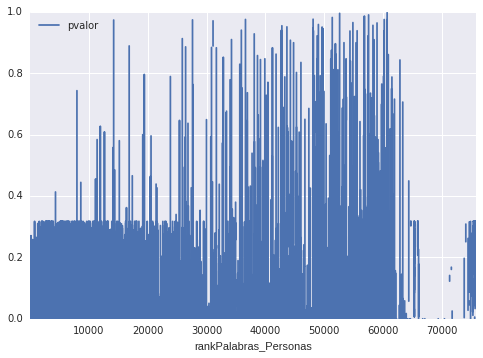

In [360]:
df4.plot(x='rankPalabras_Personas',y='pvalor')
plt.show()